### Tutorial 6 - How Use the ApplyPatches Operator

In this tutorial, we will show you how use the ApplyPatches operator, that subdivides a chunk in Patches with a given shape and apply a function at each patch. 
It is possible to define overlapping patch sets to create a similar effect of a sliding window. The recombination of the results can be done either using a Weighted Average or Voting methods.

This operator is userful when applying functions with a fixed input size (e.g. Deep Learning models), this way the interface between two neighboring patches can be smoothed due to the overlapping patches and the employement of different weight functions.


![title](imgs/tutorial_6_schematic.jpg)

#### Basic Usage

In [1]:
import numpy as np

from dasf.transforms.operations import ApplyPatchesWeightedAvg

def func(X):
    print(X.shape) # show input of 
    return X + 1

data = np.zeros((99, 99, 99))

# Here we apply only on the small cube (50, 50, 50) as its the only whole patch that can be extracted.
# Fails when using Dask arrays
patches_op = ApplyPatchesWeightedAvg(
    function=func,
    weight_function=None, # Defaults to Arithmetic Mean
    input_size=(50, 50, 50),
    overlap=None, 
    offsets=[],
)
out_1 = patches_op.transform(data)
print(f"Output shape is only {out_1.shape}, because its the only whole patch that can be extarcted without overlap/padding. Only 1 patch extarcted")

# Adding overlap (from Dask) it will pad the chunk/numpy array with the specified value 
# or get the values from neighboring chunks
patches_op = ApplyPatchesWeightedAvg(
    function=func,
    weight_function=None, # Defaults to Arithmetic Mean
    input_size=(50, 50, 50),
    overlap={"padding": (1, 1, 1), "boundary": 0},
    offsets=[],
)
out_2 = patches_op.transform(data)
print(f"Now the output shape is {out_2.shape}, because we added an overlap/padding that makes it possible to extract patches that cover the whole data. 8 patches extracted")

# Adding overlap (from Dask) it will pad the chunk/numpy array with the specified value 
# or get the values from neighboring chunks
patches_op = ApplyPatchesWeightedAvg(
    function=func,
    weight_function=None, # Defaults to Arithmetic Mean
    input_size=(50, 50, 50),
    overlap={"padding": (1, 1, 1), "boundary": 0},
    offsets=[(0, -1, -1)],
)
out_3 = patches_op.transform(data)
print(f"The output shape is {out_3.shape} is the same, but we compute 8 patches from the base set and 8 from an overlapping set (patch extraction starts at (0, -1, -1), instead of (0, 0, 0))")


(50, 50, 50)
Output shape is only (50, 50, 50), because its the only whole patch that can be extarcted without overlap/padding. Only 1 patch extarcted
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
Now the output shape is (99, 99, 99), because we added an overlap/padding that makes it possible to extract patches that cover the whole data. 8 patches extracted
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
(50, 50, 50)
The output shape is (99, 99, 99) is the same, but we compute 8 patches from the base set and 8 from an overlapping set (patch extraction starts at (0, -1, -1), instead of (0, 0, 0))


#### Using different weight functions
Weight functions can be passed to the ApplyPatches operator in order to attribute weights based on the position of a given point in the NDArray.

Below we show the Gaussian and Radial weight functions

In [2]:
from dasf.utils.funcs import weight_gaussian, weight_radial
import matplotlib.pyplot as plt
import numpy as np

In [3]:
weights = {
    "Gaussian": weight_gaussian((100, 100, 100)),
    "Radial": weight_radial((100, 100, 100))
}

In [4]:
def plot_panel(base_name, data_dict, outer, same_scale=False, transpose=False, cmap="bone"):
    f, axarr = plt.subplots(1,len(data_dict), sharex = True,sharey=True)
    mi = 1
    ma = 1
    for v in data_dict.values():
        mi = min(mi, np.min(v))
        ma = max(ma, np.max(v))
    f.set_size_inches(15,5)
    for i, data in enumerate(data_dict.items()):
        ax = axarr[i] if len(data_dict) != 1 else axarr
        panel = data[1][outer,:,:]
        panel = panel.T if transpose else panel
        if same_scale:
            subfig = ax.imshow(panel, cmap=cmap, vmin=mi, vmax=ma, interpolation='nearest')
        else:
            subfig = ax.imshow(panel, cmap=cmap, interpolation='nearest')
        ax.title.set_text(f"{base_name} - {data[0]}")
        f.colorbar(subfig, ax=ax)
        f.show()
        
def plot_lines(base_name, data_dict, outer, outer_2):
    f, axarr = plt.subplots(1,len(data_dict), sharex = True,sharey=False)
    f.set_size_inches(10,5)
    for i, data in enumerate(data_dict.items()):
        ax = axarr[i] if len(data_dict) != 1 else axarr
        line = data[1][outer,outer_2,:]
        ax.plot(np.arange(len(line)), line, label=data[0])
        ax.title.set_text(f"{base_name} - {data[0]}")
        f.show()

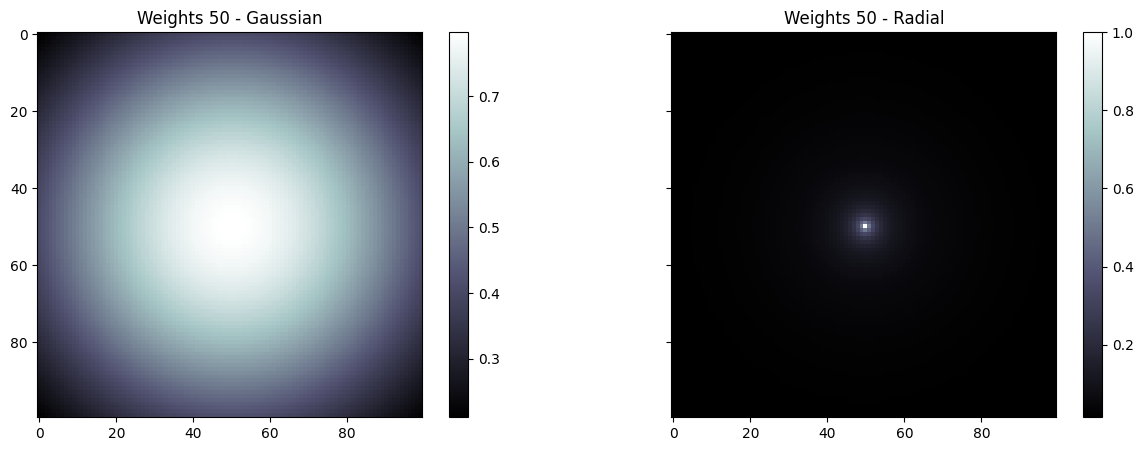

In [5]:
plot_panel("Weights 50", weights, 50)

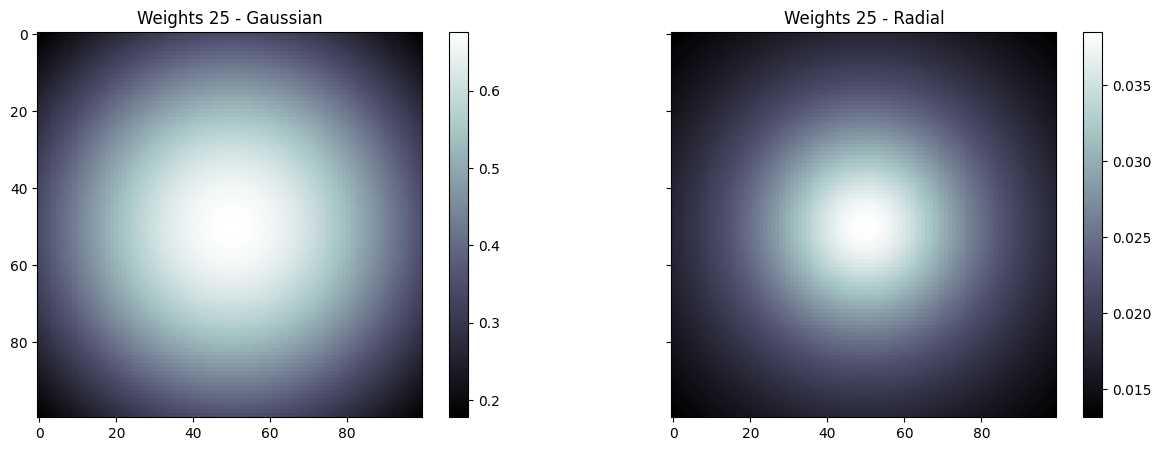

In [6]:
plot_panel("Weights 25", weights, 25)

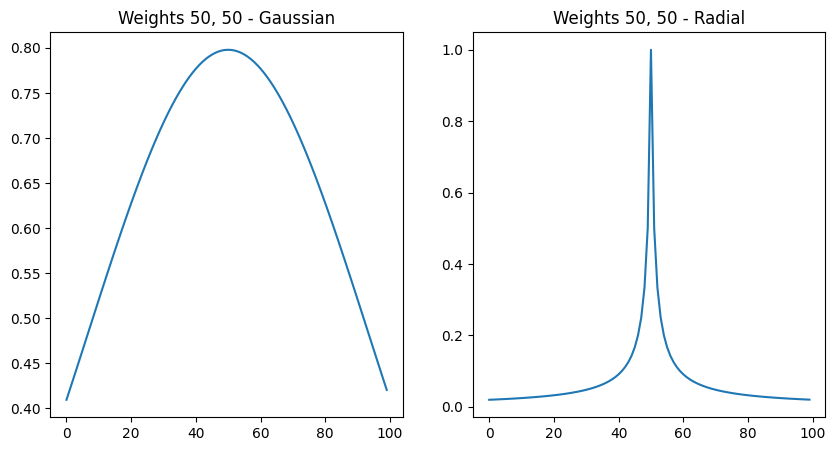

In [7]:
plot_lines("Weights 50, 50", weights, 50, 50)

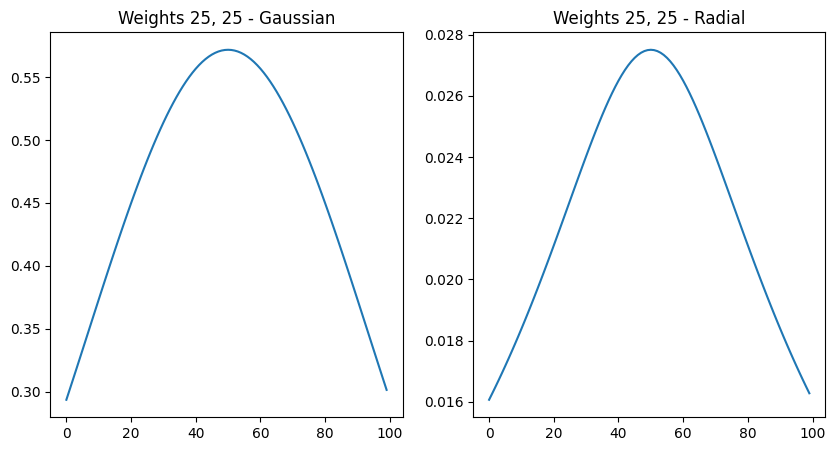

In [8]:
plot_lines("Weights 25, 25", weights, 25, 25)

#### Model Inference

In [9]:
import dask.array as da
import torch
import time
import numpy as np
try:
    import cupy as cp
except:
    pass

from dasf.transforms.operations import ApplyPatchesVoting
from dasf.transforms import Transform, ExtractData
from dasf.datasets import DatasetZarr
from dasf.pipeline import Pipeline
from dasf.ml.inference.loader.torch import TorchLoader
from dasf.pipeline.executors import DaskPipelineExecutor
from dasf.utils.funcs import get_dask_running_client


In [10]:
# Execution Params
data_path = ""
model = ""
model_definition_file = ""
checkpoint = None
device = "gpu"

# Global Min and Max must be obtained from input data
data = da.from_zarr(data_path)
glbl_mi = da.min(data).compute()
globl_ma = da.max(data).compute()
voting = "soft"  # hard or soft
output_1 = ""
output_2 = ""
chunks = {
    0: 3,
    1: 384,
    2: 384
}

# Pipeline Executor
scheduler_ip = "" # To run this experiment create a Dask Cluster prior to executing this cell
port = ""
executor = DaskPipelineExecutor(local=False, use_gpu=device=="gpu", address=scheduler_ip, port=port)

In [ ]:
client = get_dask_running_client()
client.upload_file(model_definition_file) # might be necessary to upload the model definition file to workers

In [12]:
OFFSETS = [
    [],
    [(0, -64, -64)],
    [(0, -16, -16), (0, -32, -32), (0, -64, -64)],
    [(0, -12, -12), (0, -24, -24), (0, -36, -36), (0, -48, -48), (0, -60, -60), (0, -72, -72),(0, -84, -84), (0, -96, -96), (0, -108, -108)],
    [(0, 0, -12), (0, 0, -24), (0, 0, -36), (0, 0, -48), (0, 0, -60), (0, 0, -72),(0, 0, -84), (0, 0, -96), (0, 0, -108),
     (0, -12, -12), (0, -12, -24), (0, -12, -36), (0, -12, -48), (0, -12, -60), (0, -12, -72),(0, -12, -84), (0, -12, -96), (0, -12, -108),
     (0, -24, -12), (0, -24, -24), (0, -24, -36), (0, -24, -48), (0, -24, -60), (0, -24, -72),(0, -24, -84), (0, -24, -96), (0, -24, -108),
     (0, -36, -12), (0, -36, -24), (0, -36, -36), (0, -36, -48), (0, -36, -60), (0, -36, -72),(0, -36, -84), (0, -36, -96), (0, -36, -108),
     (0, -48, -12), (0, -48, -24), (0, -48, -36), (0, -48, -48), (0, -48, -60), (0, -48, -72),(0, -48, -84), (0, -48, -96), (0, -48, -108),
     (0, -60, -12), (0, -60, -24), (0, -60, -36), (0, -60, -48), (0, -60, -60), (0, -60, -72),(0, -60, -84), (0, -60, -96), (0, -60, -108),
     (0, -72, -12), (0, -72, -24), (0, -72, -36), (0, -72, -48), (0, -72, -60), (0, -72, -72),(0, -72, -84), (0, -72, -96), (0, -72, -108),
     (0, -84, -12), (0, -84, -24), (0, -84, -36), (0, -84, -48), (0, -84, -60), (0, -84, -72),(0, -84, -84), (0, -84, -96), (0, -84, -108),
     (0, -96, -12), (0, -96, -24), (0, -96, -36), (0, -96, -48), (0, -96, -60), (0, -96, -72),(0, -96, -84), (0, -96, -96), (0, -96, -108),
     (0, -108, -12), (0, -108, -24), (0, -108, -36), (0, -108, -48), (0, -108, -60), (0, -108, -72),(0, -108, -84), (0, -108, -96), (0, -108, -108),
    ]
]

In [13]:
class Finalize(Transform):
    def _lazy_transform_cpu(self, X, **kwargs):
        return X

    def _lazy_transform_gpu(self, X, **kwargs):
        return X.map_blocks(cp.asnumpy)

    def _transform_cpu(self, X, **kwargs):
        return X

    def _transform_gpu(self, X, **kwargs):
        return cp.asarray(X)
    
class SaveZarr(Transform):
    def __init__(self, output):
        self._output = output
    def transform(self, X):
        X = X.to_zarr(self._output)
        return X
    
class ModelLoader(TorchLoader):
    def preprocessing(self, data):
        data = (2*data - (glbl_mi+globl_ma))/(globl_ma - glbl_mi)
        data = np.concatenate([data, np.zeros(data.shape), np.zeros(data.shape)] , axis=1)
        return data
    
    def postprocessing(self, data):
        data = np.transpose(data, (0, 2, 3, 1))
        data = np.expand_dims(data, axis=1)
        return data
    
    def inference(self, model, data):
        data = torch.from_numpy(data)
        device = torch.device("cuda" if self.device == "gpu" else "cpu")
        data = data.to(device, dtype=self.dtype)
        with torch.no_grad():
            output = torch.softmax(model(data), dim=1)
        return output.cpu().numpy() if self.device == "gpu" else output.numpy()

In [14]:
# Without Overlap
dataset = DatasetZarr(name="Input data", root=data_path, download=False, chunks=chunks)
data = ExtractData()
loader = ModelLoader(
    model_class_or_file=model,
    dtype=torch.float32,
    checkpoint=checkpoint,
    device=device
)

apply_patches = ApplyPatchesVoting(loader,
                             weight_function=None,
                             input_size=(1, 128, 128), 
                             overlap={
                                 "padding": (0, 128, 128),
                                  "boundary": 0,
                             },
                             offsets=OFFSETS[0],
                             voting=voting,
                             num_classes=21
)
finalize = Finalize()

save = SaveZarr(output_1)


# Create the pipeline
pipeline = Pipeline("Model Inference...", executor=executor)
pipeline.add(data, X=dataset)
pipeline.add(loader)
pipeline.add(apply_patches, X=data, model=loader)
pipeline.add(finalize, X=apply_patches)
pipeline.add(save, X=finalize)


In [15]:
start = time.time()
pipeline.run()
end = time.time()
print(f"Execution without overlap took {end-start} seconds")

[2024-05-12 20:21:22-0300] INFO - Beginning pipeline run for 'Model Inference...'
[2024-05-12 20:21:22-0300] INFO - Task 'DatasetZarr.load': Starting task run...
[2024-05-12 20:21:22-0300] INFO - Task 'DatasetZarr.load': Finished task run
[2024-05-12 20:21:22-0300] INFO - Task 'ModelLoader.load': Starting task run...
[2024-05-12 20:21:23-0300] INFO - Task 'ModelLoader.load': Finished task run
[2024-05-12 20:21:23-0300] INFO - Task 'Data.transform': Starting task run...
[2024-05-12 20:21:23-0300] INFO - Task 'Data.transform': Finished task run
[2024-05-12 20:21:23-0300] INFO - Task 'ApplyPatchesVoting.transform': Starting task run...
[2024-05-12 20:21:23-0300] INFO - Task 'ApplyPatchesVoting.transform': Finished task run
[2024-05-12 20:21:23-0300] INFO - Task 'Finalize.transform': Starting task run...
[2024-05-12 20:21:23-0300] INFO - Task 'Finalize.transform': Finished task run
[2024-05-12 20:21:23-0300] INFO - Task 'SaveZarr.transform': Starting task run...
[2024-05-12 20:21:31-0300] 

In [16]:
# With Overlap
dataset = DatasetZarr(name="Input data", root=data_path, download=False, chunks=chunks)
data = ExtractData()
loader = ModelLoader(
    model_class_or_file=model,
    dtype=torch.float32,
    checkpoint=checkpoint,
    device=device
)

apply_patches = ApplyPatchesVoting(loader,
                             weight_function=None,
                             input_size=(1, 128, 128), 
                             overlap={
                                 "padding": (0, 128, 128),
                                  "boundary": 0,
                             },
                             offsets=OFFSETS[4],
                             voting=voting,
                             num_classes=21
)
finalize = Finalize()

save = SaveZarr(output_2)


# Create the pipeline
pipeline = Pipeline("Model Inference...", executor=executor)
pipeline.add(data, X=dataset)
pipeline.add(loader)
pipeline.add(apply_patches, X=data, model=loader)
pipeline.add(finalize, X=apply_patches)
pipeline.add(save, X=finalize)


In [17]:
start = time.time()
pipeline.run()
end = time.time()
print(f"Execution with overlap took {end-start} seconds")

Execution with overlap took 667.155853509903 seconds


In [18]:
results = {
    "No Overlap": da.from_zarr(output_1).compute(),
    "Overlap": da.from_zarr(output_2).compute()
}

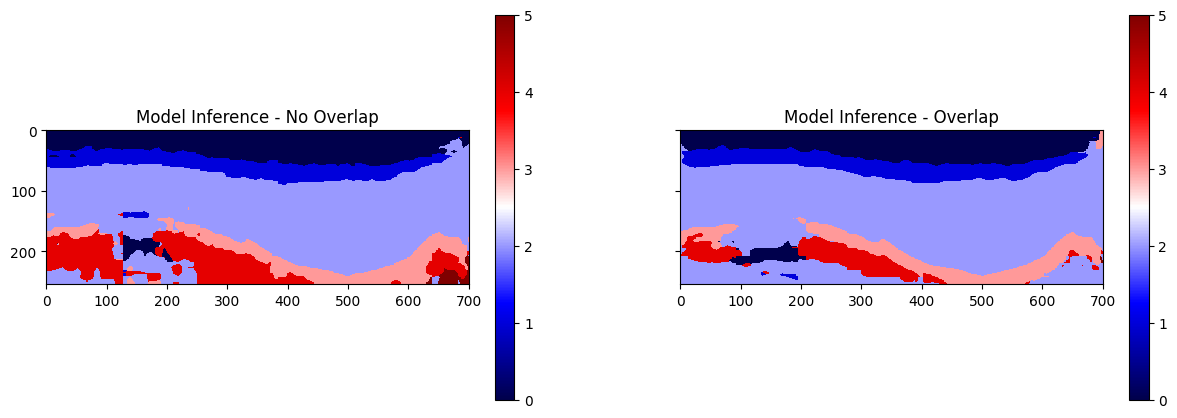

In [19]:
plot_panel("Model Inference", results, 10, same_scale=True, transpose=True, cmap="seismic")